In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
# Import MCMC first so that JAX gets set up with 8 cores.
import berrylib.mcmc as mcmc

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import logit

import berrylib.fast_inla as fast_inla
import berrylib.quadrature as quadrature

/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up some tools for plotting

We want to plot two main things:
1. The posterior arm marginal: $p(\theta_i | y)$
2. The hyperparameter posterior: $p(\sigma^2 | y)$

In [31]:
def run_mcmc(fi, y, n, n_samples=20000):
    return mcmc.mcmc_berry(
        np.stack((y, n), axis=-1),
        fi.logit_p1,
        fi.thresh_theta,
        dtype=np.float64,
        n_samples=n_samples
    )

In [74]:
def compare_arm_marginals(fi, y, n, arm_idx, plot_idx, ti_N=51, results_mcmc=None, n_theta=15, n_samples=20000, include_laplace=False, show=True):
    data = np.stack((y, n), axis=-1)
    if results_mcmc is None:
        results_mcmc = run_mcmc(
            fi, y[plot_idx : (plot_idx + 1)], n[plot_idx : (plot_idx + 1)],
            n_samples=n_samples
        )
        mcmc_arm = results_mcmc["x"][0]["theta"][0, :, arm_idx]
    else: 
        mcmc_arm = results_mcmc["x"][plot_idx]["theta"][0, :, arm_idx]
    if not isinstance(mcmc_arm, np.ndarray):
        mcmc_arm = mcmc_arm.to_py()

    # print('arm_idx=', arm_idx, ' y=', y[plot_idx])
    ti_rule = util.simpson_rule(ti_N, -6.0, 2.0)

    sigma2_post, _, theta_mu, theta_sigma, _ = fi.numpy_inference(data)

    integrate_dims = list(range(fi.n_arms))
    integrate_dims.remove(arm_idx)
    quad_p_ti_g_y = quadrature.integrate(
        fi,
        y[plot_idx],
        n[plot_idx],
        integrate_sigma2=True,
        fixed_arm_dim=arm_idx,
        fixed_arm_values=ti_rule.pts,
        n_theta=n_theta,
    )
    quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts)

    gaussian_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        theta_mu[plot_idx, :, arm_idx],
        theta_sigma[plot_idx, :, arm_idx],
    )
    gaussian_p_ti_g_y = np.sum(
        gaussian_pdf * sigma2_post[plot_idx] * fi.sigma2_rule.wts[None, :], axis=1
    )

    # construct bin edges such that the bin midpoints correspond to ti_rule.pts
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, ti_rule.pts, ti_rule.wts)

    if include_laplace:
        y_tiled = np.tile(y, (ti_rule.pts.shape[0], 1))
        n_tiled = np.tile(n, (ti_rule.pts.shape[0], 1))
        ti_pts_tiled = np.tile(ti_rule.pts[:, None], (1, fi.sigma2_n)) 

        ti_max, ti_hess_inv = fi.optimize_mode(y_tiled, n_tiled, fixed_arm_dim=arm_idx, fixed_arm_values=ti_pts_tiled)
        ti_logjoint = fi.log_joint(y_tiled, n_tiled, ti_max)

        ti_post = np.exp(ti_logjoint + 0.5 * np.log(np.linalg.det(-ti_hess_inv)))
        ti_post /= np.sum(ti_post * ti_rule.wts[:, None], axis=0)
        laplace_p_ti_g_y = np.sum(ti_post * sigma2_post * fi.sigma2_rule.wts, axis=1)
        plt.plot(ti_rule.pts, laplace_p_ti_g_y, "k-x", markersize=7, label="INLA-Laplace")


    plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "k-", markersize=3, label="INLA")
    plt.plot(ti_rule.pts, quad_p_ti_g_y, "k--", markersize=3, label="Quadrature")
    plt.plot(ti_rule.pts, mcmc_p_ti_g_y, "k.", label="MCMC")

    y_str = ', '.join([str(v) for v in y.astype(np.int32)[plot_idx]])
    n_str = ', '.join([str(v) for v in n.astype(np.int32)[plot_idx]])
    plt.title(f'y=[{y_str}]  n=[{n_str}]')

    plt.xlabel(r"$\theta_" + str(arm_idx) + "$")
    plt.ylabel(r"$p(\theta_" + str(arm_idx) + " \| y)$")
    plt.legend()
    if show:
        plt.show()


In [61]:
def compare_hyperparam_posterior(fi, y, n, plot_idx, results_mcmc=None, n_theta=15):
    if results_mcmc is None:
        results_mcmc = run_mcmc(
            fi, y[plot_idx : (plot_idx + 1)], n[plot_idx : (plot_idx + 1)]
        )
        mcmc_sigma2 = results_mcmc["x"][0]["sigma2"][0, :]
    else: 
        mcmc_sigma2 = results_mcmc["x"][plot_idx]["sigma2"][0, :]
    if not isinstance(mcmc_sigma2, np.ndarray):
        mcmc_sigma2 = mcmc_sigma2.to_py()

    sigma2_post, _, theta_mu, theta_sigma, _ = fi.numpy_inference(np.stack((y, n), axis=-1))

    quad_p_s2_g_y = quadrature.integrate(
        fi,
        y[plot_idx],
        n[plot_idx],
        integrate_sigma2=False,
        n_theta=n_theta,
    )
    quad_p_s2_g_y /= np.sum(quad_p_s2_g_y * fi.sigma2_rule.wts)

    mcmc_p_s2_g_y = mcmc.calc_pdf(mcmc_sigma2, fi.sigma2_rule.pts, fi.sigma2_rule.wts)

    plt.plot(np.log10(fi.sigma2_rule.pts), sigma2_post[plot_idx], "k-", markersize=3, label="INLA-Gaussian")
    plt.plot(np.log10(fi.sigma2_rule.pts), quad_p_s2_g_y, "k--", markersize=3, label="Quad")
    plt.plot(np.log10(fi.sigma2_rule.pts), mcmc_p_s2_g_y, "ko", markersize=3, label="MCMC")
    plt.xlabel('$\log_{10} (\sigma^2)$')
    plt.ylabel('$p(\sigma^2 \| y)$')
    plt.legend()
    plt.show()

    plt.plot(np.log10(fi.sigma2_rule.pts), sigma2_post[plot_idx] * fi.sigma2_rule.wts, "k-", markersize=3, label="INLA-Gaussian")

    y_str = ', '.join([str(v) for v in y.astype(np.int32)[plot_idx]])
    n_str = ', '.join([str(v) for v in n.astype(np.int32)[plot_idx]])
    plt.title(f'y=[{y_str}]  n=[{n_str}]')

    plt.plot(np.log10(fi.sigma2_rule.pts), quad_p_s2_g_y * fi.sigma2_rule.wts, "k--", markersize=3, label="Quad")
    plt.plot(np.log10(fi.sigma2_rule.pts), mcmc_p_s2_g_y * fi.sigma2_rule.wts, "ko", markersize=3, label="MCMC")
    plt.legend()
    plt.xlabel('$\log_{10} (\sigma^2)$')
    plt.ylabel('$p(\sigma^2 \| y) * w$')
    plt.show()

## Exploring a 2D grid.

Every situation where $y_i \in \{0, 1, ..., 9\}$

In [62]:
fi = fast_inla.FastINLA(n_arms=2, sigma2_n=90)

# Compute for a grid of y values ranging from 0 to 9 with n = 35
ys = np.arange(0, 10)
Y1, Y2 = np.meshgrid(ys, ys)
ygrid = np.stack((Y1.ravel(), Y2.ravel()), axis=-1)
ngrid = np.full_like(ygrid, 35)

In [63]:
import pickle
mcmc_filename = 'mcmc_grid.pkl'
load = True
if load:
    with open(mcmc_filename, 'rb') as f:
        results_mcmc = pickle.load(f)
else:
    results_mcmc = run_mcmc(fi, ygrid, ngrid)
    with open(mcmc_filename, 'wb') as f:
        pickle.dump(results_mcmc, f)

In [64]:
plot_idx = 84
arm_idx = 0
y = ygrid[plot_idx:(plot_idx + 1)]
n = ngrid[plot_idx:(plot_idx + 1)]
sigma2_post, _, theta_mu, theta_sigma, _ = fi.numpy_inference(np.stack((y, n), axis=-1))

In [65]:
ti_rule = util.simpson_rule(51, -3.0, 1.0)
gaussian_pdf = scipy.stats.norm.pdf(
    ti_rule.pts[:, None],
    theta_mu[0, :, arm_idx],
    theta_sigma[0, :, arm_idx],
)

In [66]:
T, S = np.meshgrid(ti_rule.pts, fi.sigma2_rule.pts, indexing='ij')

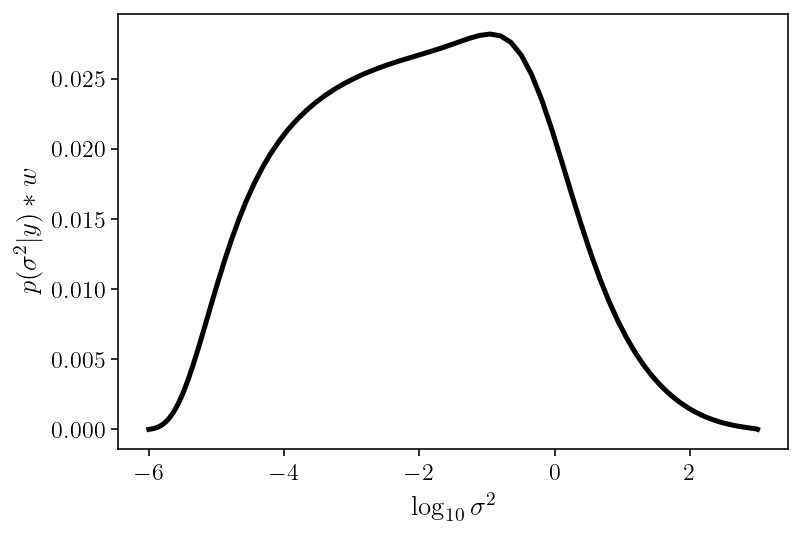

In [67]:
plt.plot(np.log10(fi.sigma2_rule.pts), sigma2_post[0] * fi.sigma2_rule.wts, 'k-', linewidth=2.5)
plt.xlabel('$\log_{10} \sigma^2$')
plt.ylabel('$p(\sigma^2 | y) * w$')
plt.show()

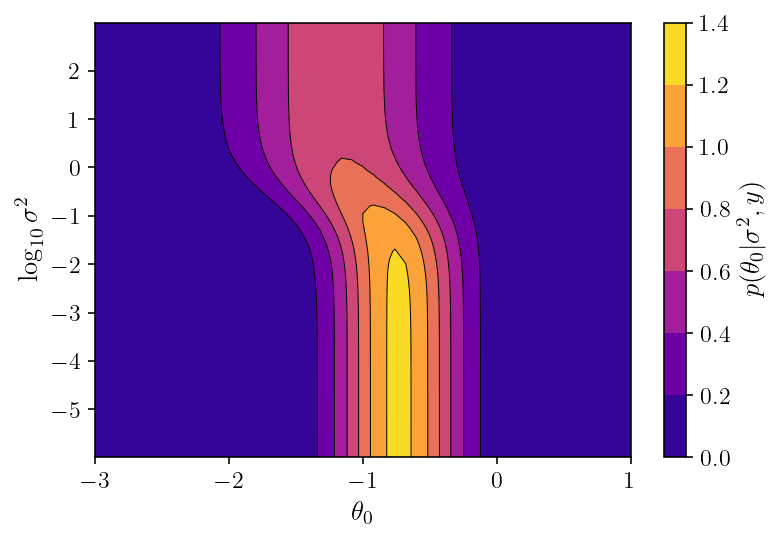

In [68]:
cntf = plt.contourf(T, np.log10(S), gaussian_pdf)# * sigma2_post * fi.sigma2_rule.wts)
plt.contour(
    T,
    np.log10(S),
    gaussian_pdf,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    # levels=levels,
    extend="both",
)
cbar = plt.colorbar(cntf)
plt.xlabel(f'$\\theta_{arm_idx}$')
plt.ylabel('$\log_{10} \sigma^2$')
cbar.set_label('$p(\\theta_0 | \sigma^2, y)$')
plt.savefig('ptheta_given_sig_cntf.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
sigs = fi.sigma2_rule.pts

mcmc_results = mcmc.mcmc_berry(np.stack((y, n), axis=-1), fi.logit_p1, fi.thresh_theta, sigma2_val=sigs[0], n_samples=300000)
pdf0 = mcmc.calc_pdf(mcmc_results['x'][0]['theta'][0,:,0], ti_rule.pts, ti_rule.wts)
mcmc_results = mcmc.mcmc_berry(np.stack((y, n), axis=-1), fi.logit_p1, fi.thresh_theta, sigma2_val=sigs[50], n_samples=300000)
pdf50 = mcmc.calc_pdf(mcmc_results['x'][0]['theta'][0,:,0], ti_rule.pts, ti_rule.wts)
mcmc_results = mcmc.mcmc_berry(np.stack((y, n), axis=-1), fi.logit_p1, fi.thresh_theta, sigma2_val=sigs[89], n_samples=300000)
pdf89 = mcmc.calc_pdf(mcmc_results['x'][0]['theta'][0,:,0], ti_rule.pts, ti_rule.wts)

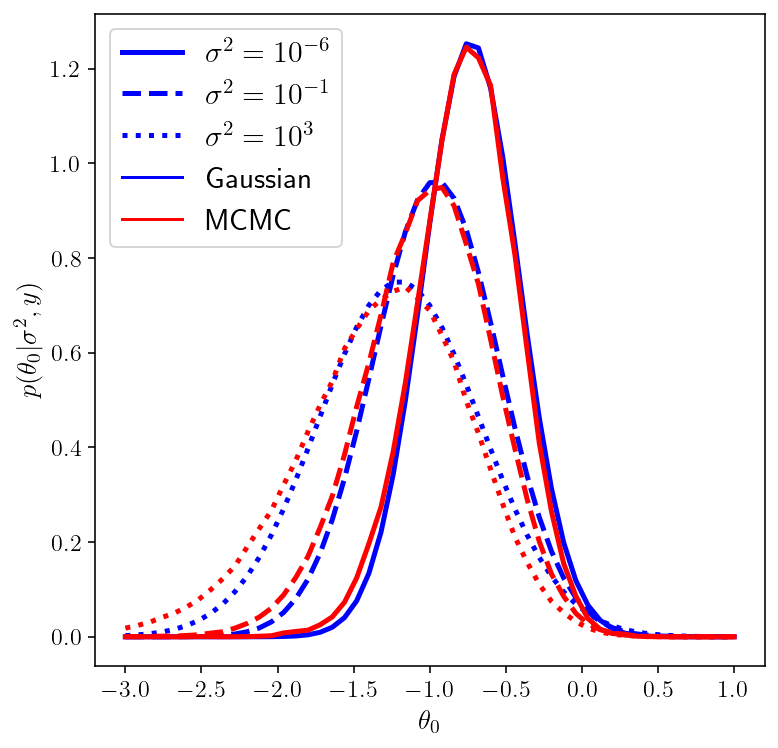

In [70]:
# for i in [0, 50, 89]:# range(0, fi.sigma2_rule.pts.shape[0], 10):
plt.figure(figsize=(6,6))
lw = 2.5
plt.plot(ti_rule.pts, gaussian_pdf[:, 0], 'b-',   linewidth=lw, label='$\sigma^2 = 10^{-6}$')
plt.plot(ti_rule.pts, gaussian_pdf[:, 50], 'b--', linewidth=lw, label='$\sigma^2 = 10^{-1}$')
plt.plot(ti_rule.pts, gaussian_pdf[:, 89], 'b:',  linewidth=lw, label='$\sigma^2 = 10^3$')
plt.plot(ti_rule.pts, pdf0,  'r-' ,linewidth=lw)
plt.plot(ti_rule.pts, pdf50, 'r--',linewidth=lw)
plt.plot(ti_rule.pts, pdf89, 'r:' ,linewidth=lw)
plt.plot([],[], 'b', label='Gaussian')
plt.plot([],[], 'r', label='MCMC')
plt.legend(loc='upper left')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$p(\theta_0 | \sigma^2, y)$')
plt.savefig('ptheta_given_sig.jpg', dpi=300, bbox_inches='tight')
plt.show()

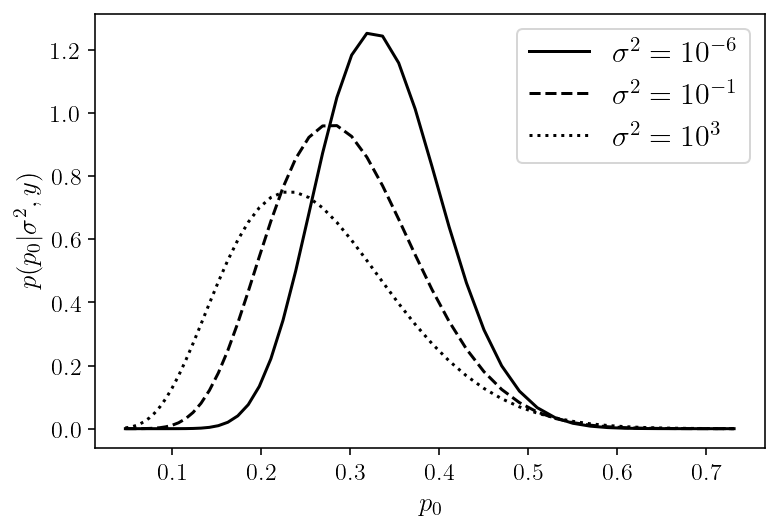

In [71]:
from scipy.special import expit
# for i in [0, 50, 89]:# range(0, fi.sigma2_rule.pts.shape[0], 10):
plt.plot(expit(ti_rule.pts), gaussian_pdf[:, 0], 'k-', label='$\sigma^2 = 10^{-6}$')
plt.plot(expit(ti_rule.pts), gaussian_pdf[:, 50], 'k--', label='$\sigma^2 = 10^{-1}$')
plt.plot(expit(ti_rule.pts), gaussian_pdf[:, 89], 'k:', label='$\sigma^2 = 10^3$')
# plt.plot(ti_rule.pts, pdf0, 'r-')
# plt.plot(ti_rule.pts, pdf50, 'r--')
# plt.plot(ti_rule.pts, pdf89, 'r:')
plt.legend()
plt.xlabel(r'$p_0$')
plt.ylabel(r'$p(p_0 | \sigma^2, y)$')
plt.savefig('p_given_sig.png', dpi=300, bbox_inches='tight')
plt.show()

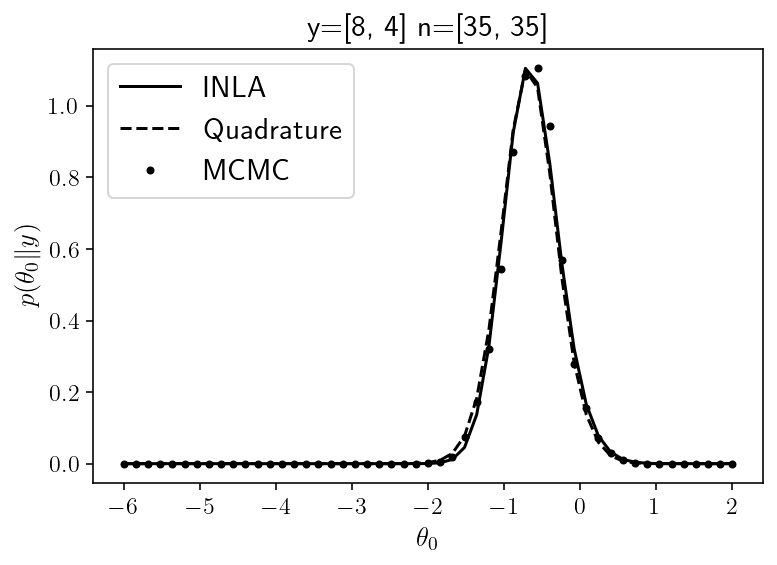

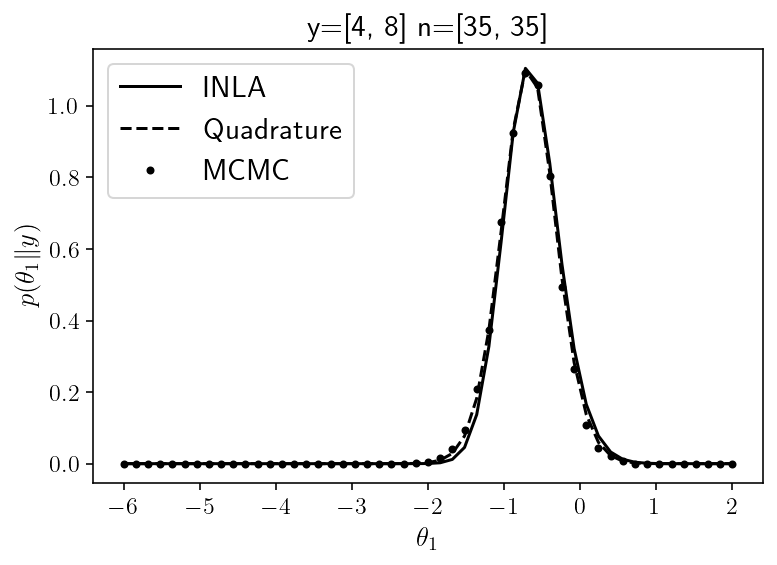

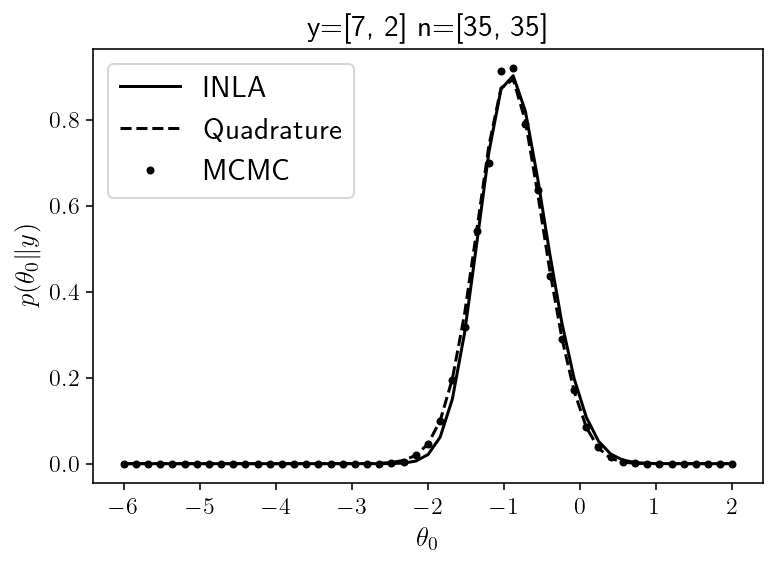

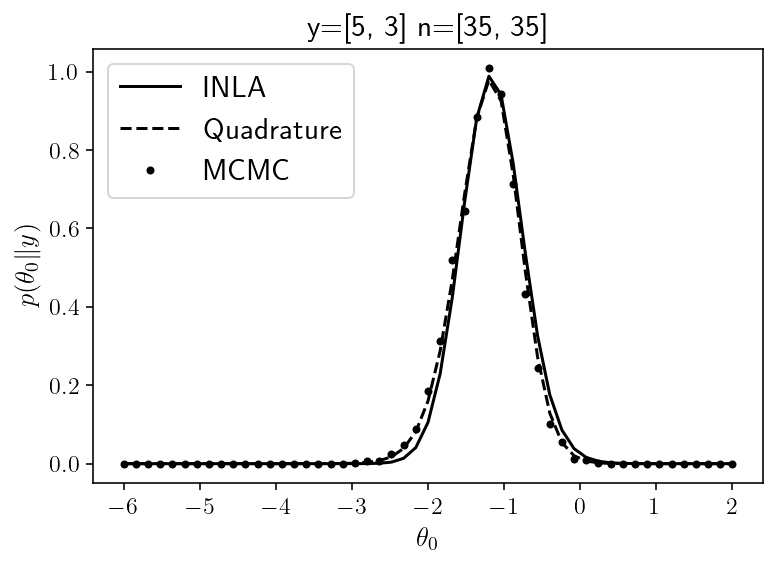

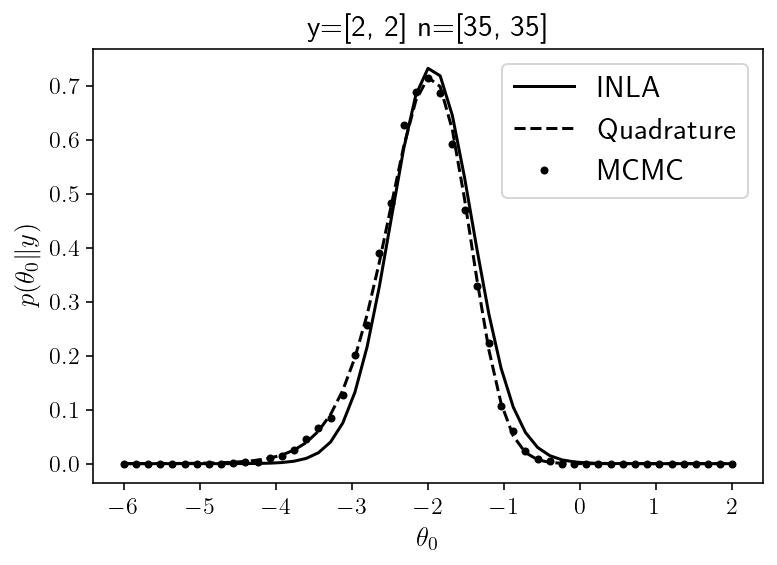

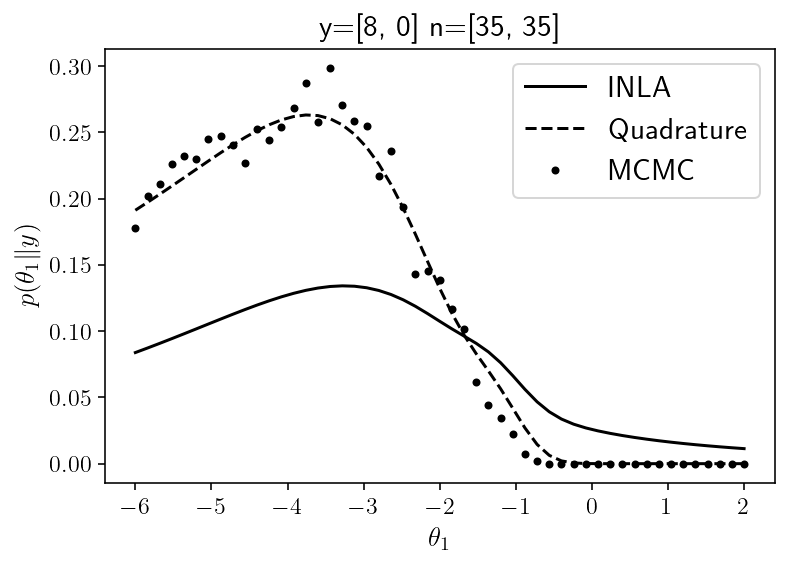

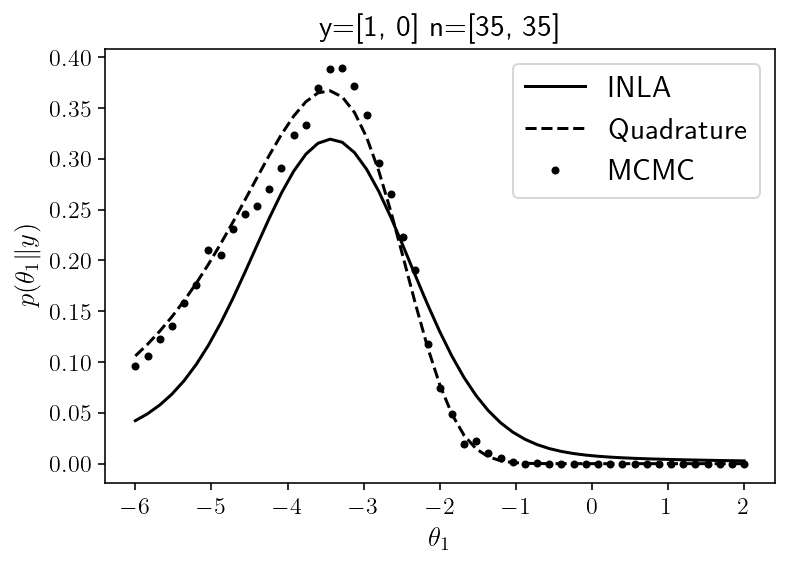

/Users/tbent/Dropbox/active/fda/imprint/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


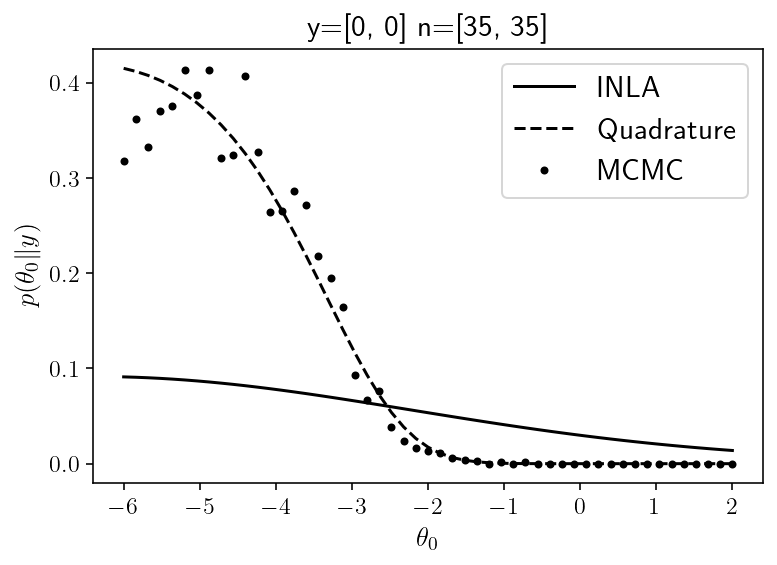

In [75]:
for arm_idx, plot_idx in [(0, 48), (1, 84), (0, 27), (0, 35), (0, 22), (1, 8), (1, 1), (0,0)]:
    compare_arm_marginals(fi, ygrid, ngrid, arm_idx, plot_idx, results_mcmc=results_mcmc, n_samples=20000)

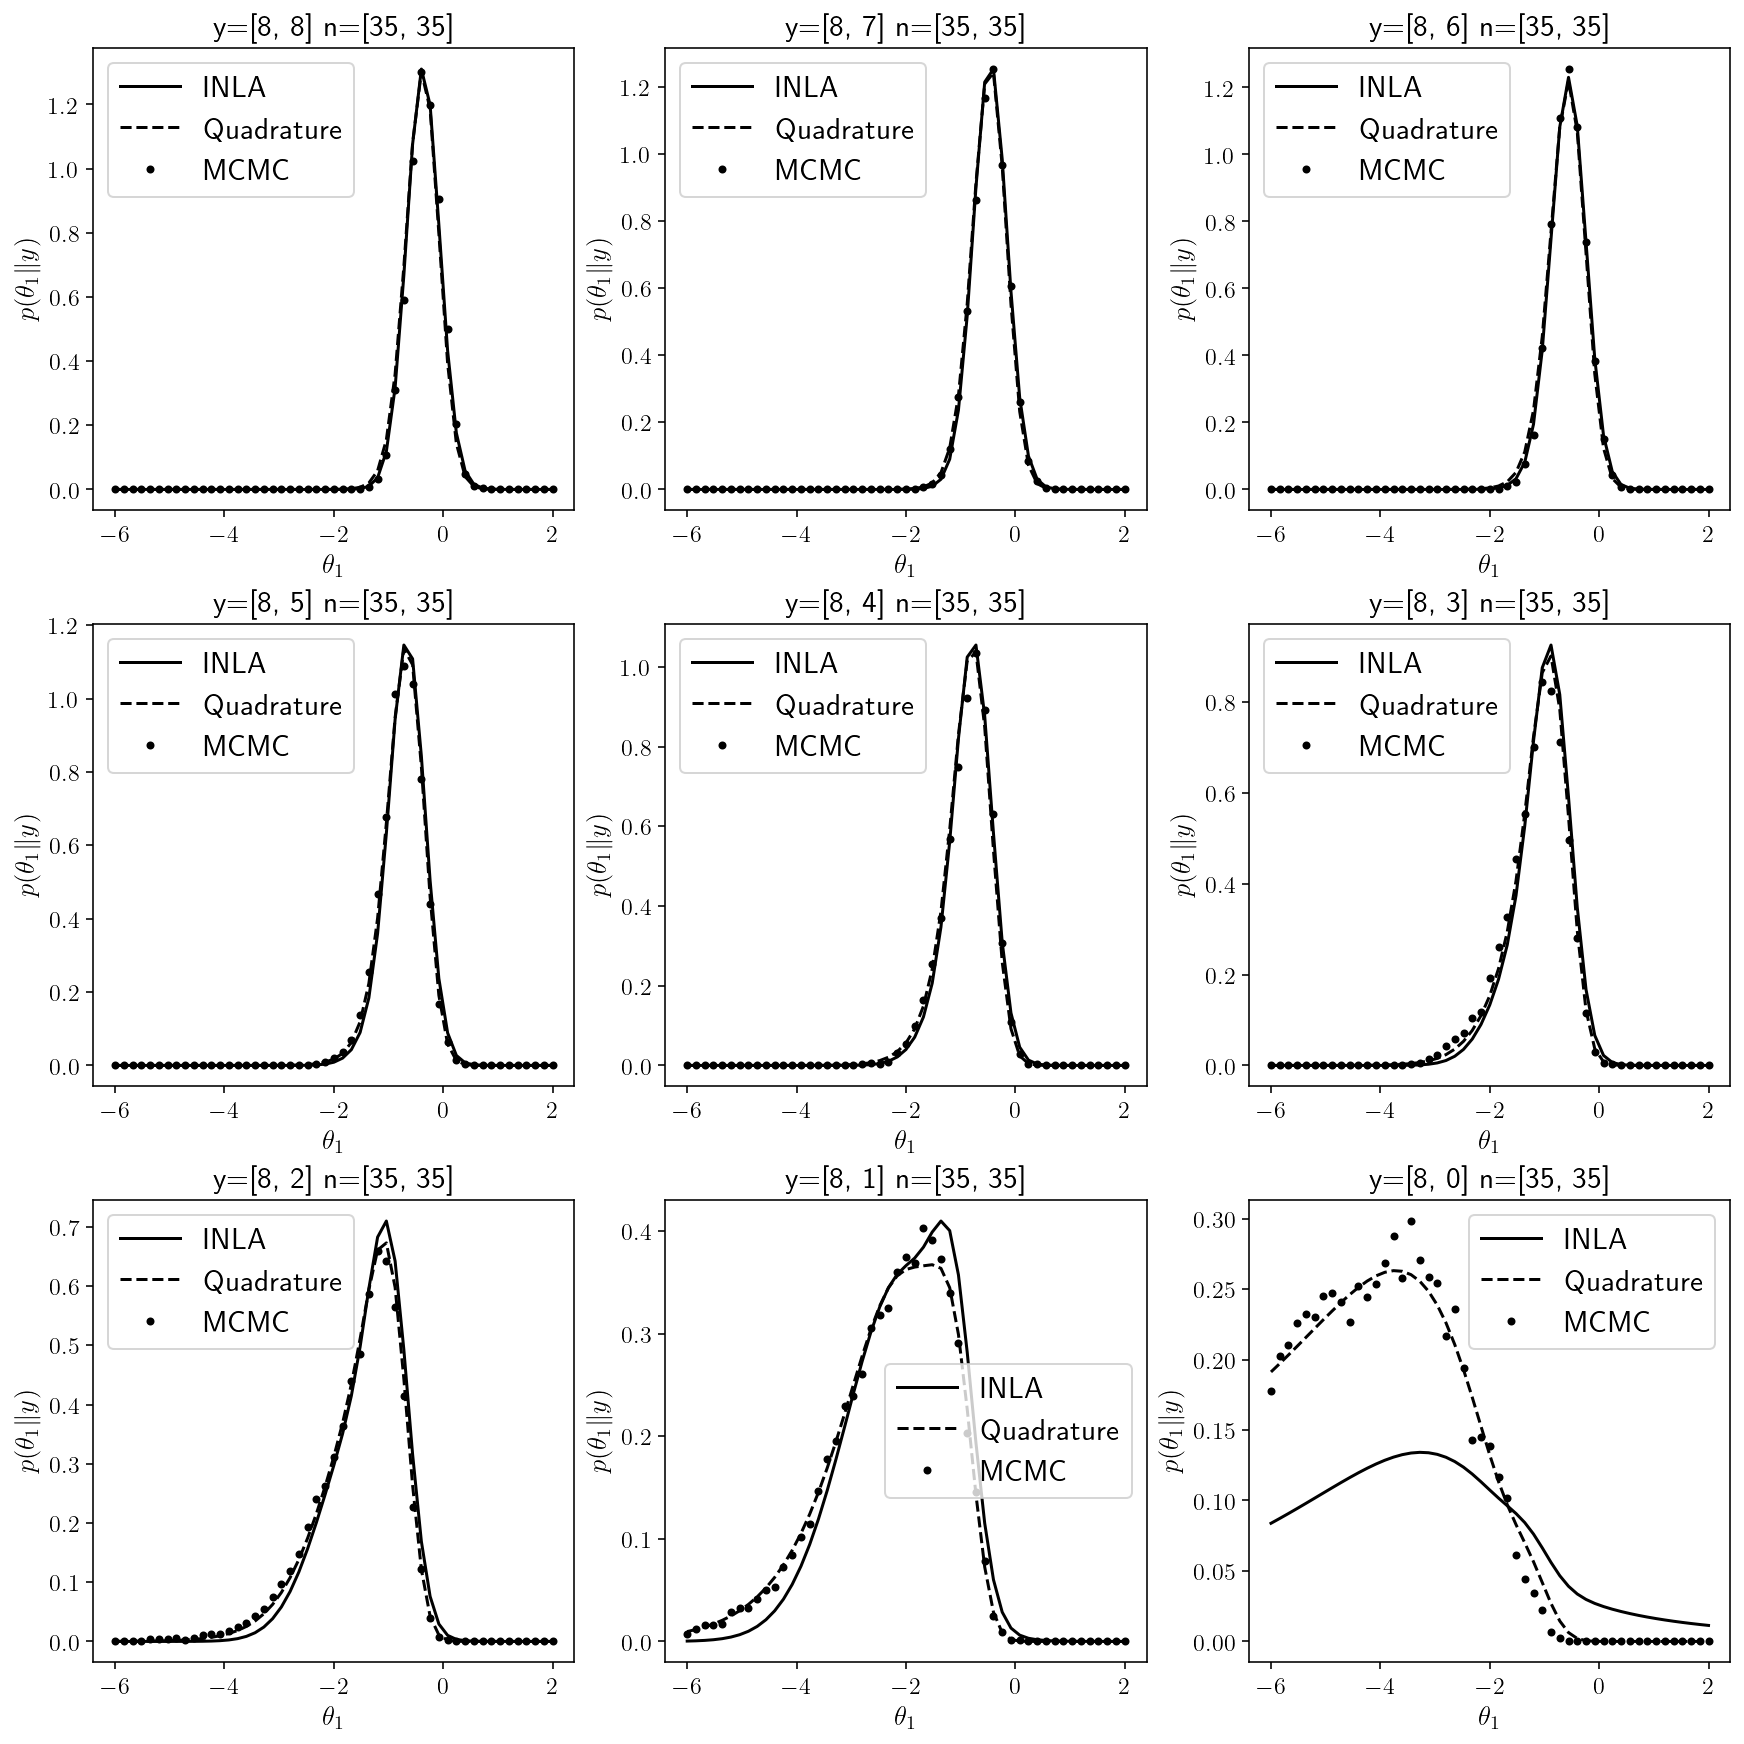

In [76]:
plt.figure(figsize = (12, 12), constrained_layout=True)
for i, (arm_idx, plot_idx) in enumerate([(1, 88), (1, 78), (1, 68), (1, 58), (1, 48), (1, 38), (1, 28), (1, 18), (1, 8)]):
    plt.subplot(3, 3, 1 + i)
    compare_arm_marginals(fi, ygrid, ngrid, arm_idx, plot_idx, results_mcmc=results_mcmc, n_samples=20000, show=False)
plt.savefig('small_y_grid.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/tbent/Dropbox/active/fda/imprint/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


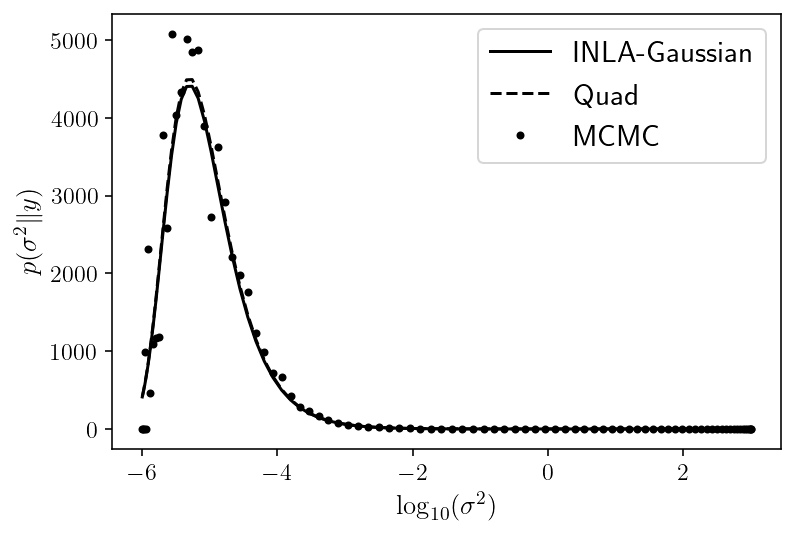

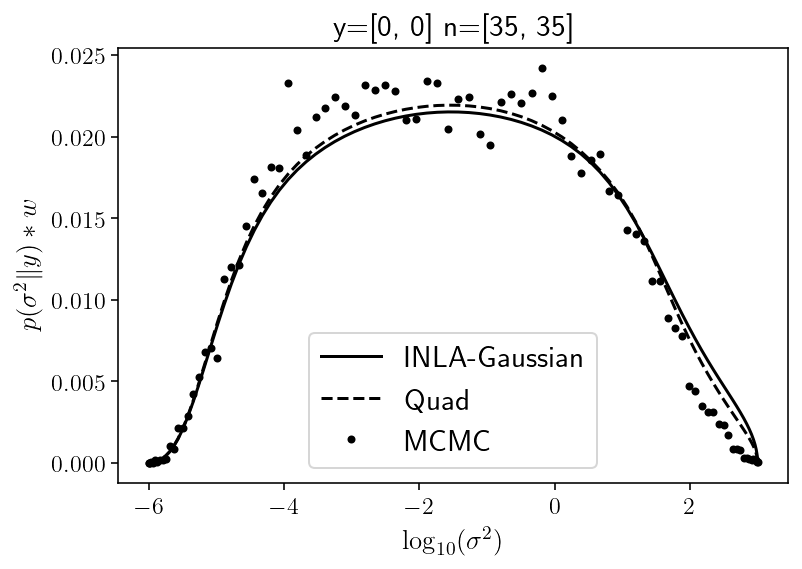

In [77]:
for arm_idx, plot_idx in [(1, 0)]:
    compare_hyperparam_posterior(fi, ygrid, ngrid, plot_idx, results_mcmc=results_mcmc)

## A 4d problem, Berry figure 2 final analysis

In [39]:
fi4 = fast_inla.FastINLA(n_arms=4, sigma2_n=90)
n4 = np.array([[20, 20, 35, 35]])
y4 = np.array([[0, 1, 9, 10]], dtype=np.float64)

In [43]:
results_mcmc4 = run_mcmc(fi4, y4, n4, n_samples=500000)

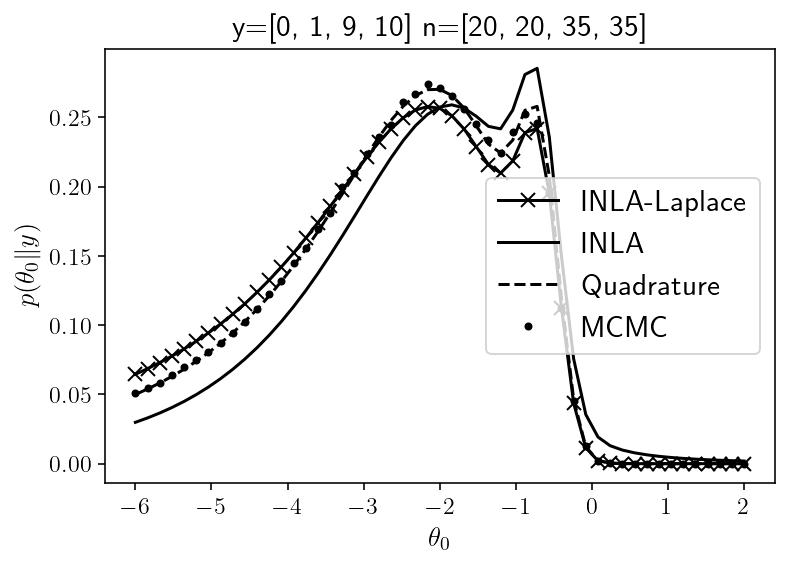

/Users/tbent/Dropbox/active/fda/imprint/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


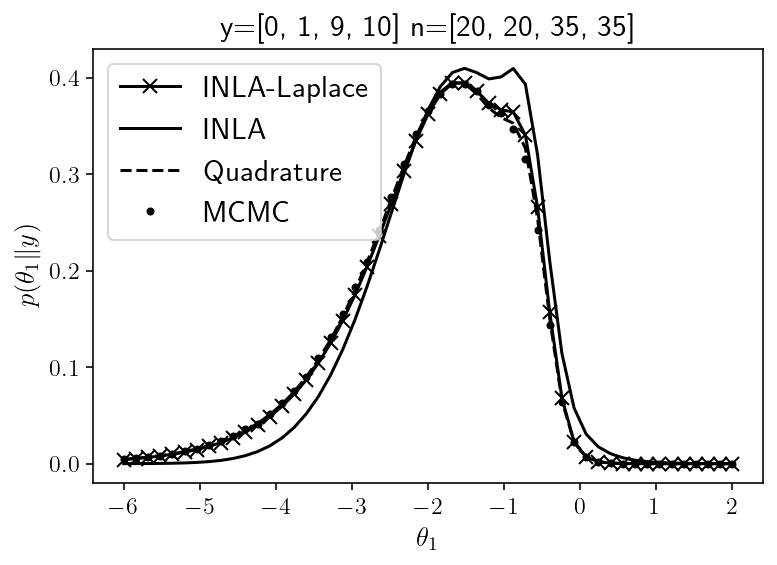

/Users/tbent/Dropbox/active/fda/imprint/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


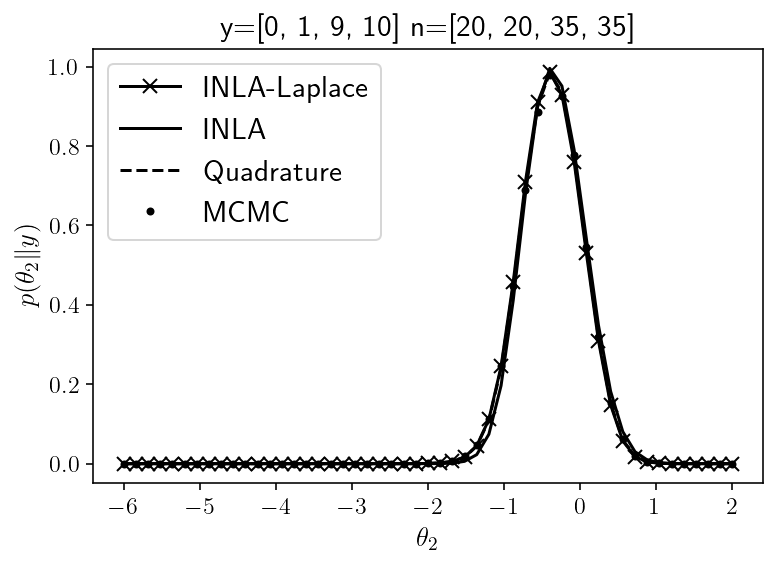

/Users/tbent/Dropbox/active/fda/imprint/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


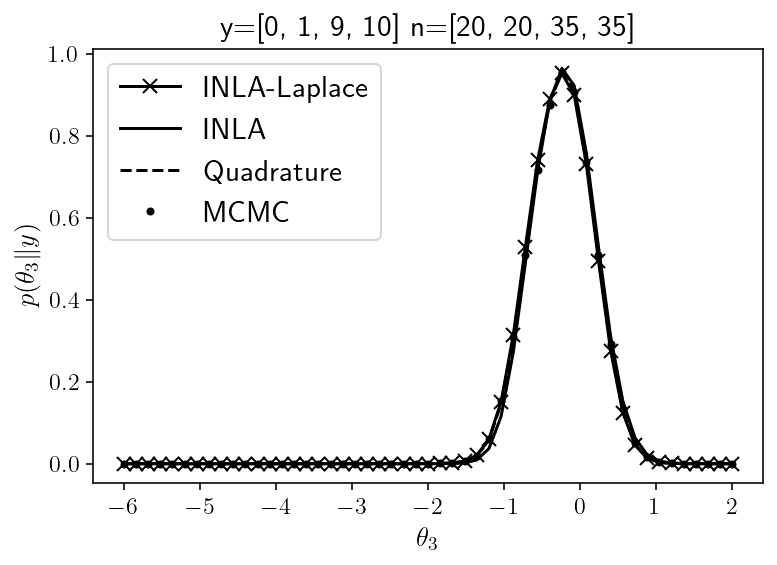

In [78]:
for arm_idx in range(4):
    compare_arm_marginals(fi4, y4, n4, arm_idx, 0, results_mcmc=results_mcmc4, n_theta=11, include_laplace=True)

/Users/tbent/Dropbox/active/fda/imprint/research/berry/berrylib/fast_inla.py:226: RuntimeWarning: overflow encountered in exp
  exp_theta_adj = np.exp(theta_adj)


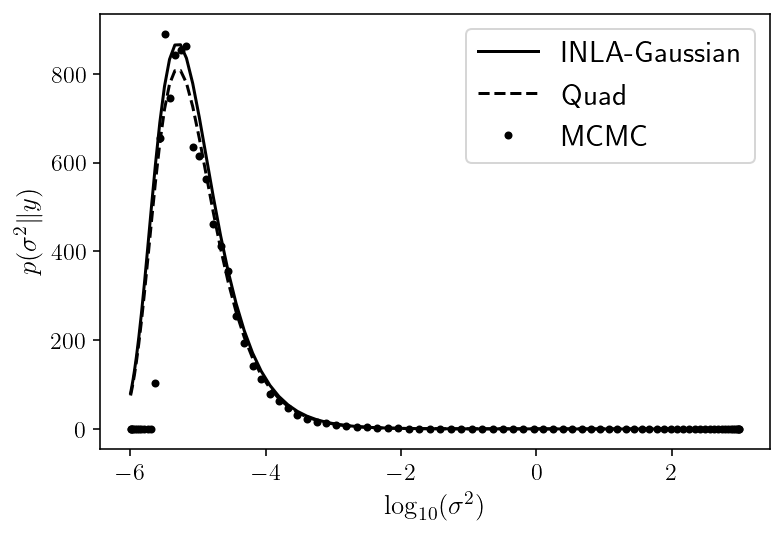

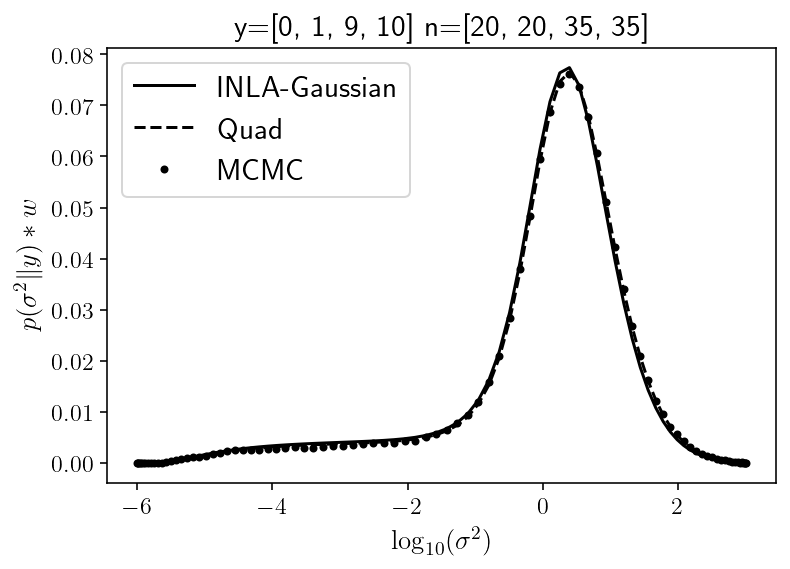

In [79]:
compare_hyperparam_posterior(fi4, y4, n4, 0, results_mcmc=results_mcmc4, n_theta=11)